In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method

set_start_method('spawn', force=True)

import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import *

In [6]:
import data
reload(data)
from data import TAPDataset, TAPDataLoader

run_dir = Path("../runs/hybrid_hyperparam_grid2/optimal_config_20240801_144846")
cfg, model, trainer_state, opt_state, _ = load_last_state(run_dir)
cfg['quiet'] = False

fig_dir = run_dir / "figures"
fig_dir.mkdir(exist_ok=True)

# dataset = TAPDataset(cfg)

Loading model state from ../runs/hybrid_hyperparam_grid2/optimal_config_20240801_144846/epoch050
Model contains 357,123 parameters, using 1.36MB memory.


In [ ]:
cfg['num_workers'] = 1
cfg['basin_subset'] = None
cfg['batch_size'] = 64


def save_results(data_subset):
    dataset.update_indices(data_subset)
    dataloader = TAPDataLoader(cfg, dataset)
    results = predict(model, dataloader)
    bulk_metrics = get_all_metrics(results, False)
    basin_metrics = get_basin_metrics(results, True)
    # with open(run_dir / f"{data_subset}_data.pkl", 'wb') as f:
    #     pickle.dump((results, bulk_metrics, basin_metrics), f)
        
    return results, bulk_metrics, basin_metrics


results, bulk_metrics, basin_metrics = save_results('test')
# save_results('train')

In [7]:
with open(run_dir / "test_data.pkl", 'rb') as f:
    results, bulk_metrics, basin_metrics = pickle.load(f)

In [50]:
np.sum(~np.isnan(obs))

16560

(0.7, 100000.0)

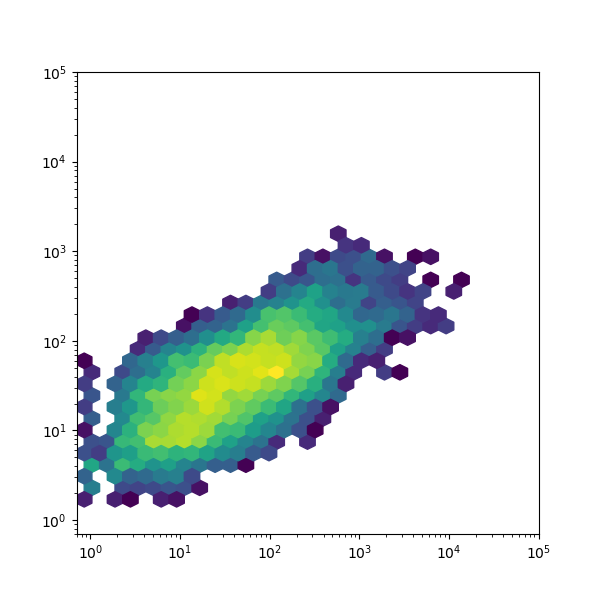

In [56]:
pred = results['pred']['ssc'].values
obs = results['obs']['ssc'].values



min_val = 7E-1
max_val = 1E5
log_min = np.log10(min_val)
log_max = np.log10(max_val)

fig, ax = plt.subplots(figsize = (6, 6))
ax.hexbin(obs, pred, gridsize=(30,20), bins='log', mincnt=5, 
                    extent=(log_min, log_max, log_min, log_max),
                    xscale='log', yscale='log')
# ax.plot([min_val, max_val], [min_val, max_val], 'r--')
ax.axis('square')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

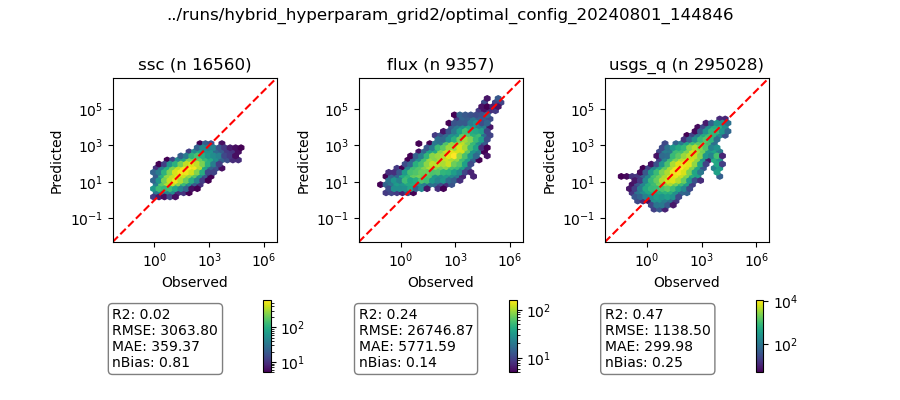

In [52]:
from evaluate import mosaic_scatter

plt.close('all')
fig = mosaic_scatter(cfg, results, bulk_metrics, str(run_dir))

plt.show()
fig.savefig(fig_dir / f"{cfg['data_subset']}_density_scatter.png",  dpi=300)


In [ ]:
min_val = 1E-1
max_val = 5E6
log_min = np.log10(min_val)
log_max = np.log10(max_val)


x = results['obs']['flux'].values
y = results['pred']['flux'].values
count = (~np.isnan(x)).sum()

mask = ~np.isnan(x) & ~np.isnan(y) & (x>0) & (y>0)
x = x[mask]
y = y[mask]

plt.figure()
hb = plt.hexbin(x, y, gridsize=(30,20), bins='log', mincnt=5, 
                    extent=(log_min, log_max, log_min, log_max),
                    xscale='log', yscale='log')

ax=plt.gca()
ax.axis('square')
ax.plot([min_val, max_val], [min_val, max_val], 'r--')
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_title(f"Flux (n={count})")

plt.show()

In [ ]:
xl = np.log10(x)
yl = np.log10(y)
np.corrcoef(xl, yl)[0,1]**2

In [ ]:
from evaluate import basin_metric_histograms

metric_args = {
    'R2': {'range':[-1,1]},
    'nBias':{'range':[-1,1]},
    'rRMSE':{'range':[0,500]},
    'KGE':{'range':[-2,1]},
    'NSE':{'range':[-2,1]},
    'Agreement':{'range':[0,1]}}

figs = basin_metric_histograms(basin_metrics, metric_args)

for target, fig in figs.items():
    fig.savefig(fig_dir / f"epoch{trainer_state['epoch']:03d}_{cfg['data_subset']}_{target}_metrics_hist.png",  dpi=300)
    

In [ ]:
import matplotlib.gridspec as gridspec

def timeseries_plot(results, feature):
    pred = results['pred'][feature]
    obs = results['obs'][feature]
    joint = results[[('obs',feature),('pred',feature)]]
    joint = joint.dropna()
    
    if len(joint) < 2:
        return
           
    # Create a figure
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
    axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]
    
    min_val = joint.min().min()
    max_val = joint.max().max()

    axes[0].loglog(obs, pred, linestyle='None',marker='.', alpha=0.2)
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')

    # Setting axes to be square and equal range
    axes[0].axis('square')
    axes[0].set_xlabel(f"Observed {feature}")
    axes[0].set_ylabel(f"Predicted {feature}")

    axes[0].set_title(f"Basin: {basin}")


    axes[1].plot(pred)
    axes[1].plot(obs, linestyle='None',marker='.',alpha=0.5)
    axes[1].set_title(f"{feature}")
    # axes[1].set_ylim([0,40000])

    textstr = '\n'.join([f"{key}: {basin_metrics.loc[basin][feature][key]:0.2f}" for key in ['rRMSE','KGE','NSE','Agreement']])
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axes[1].text(0.98, 0.97, textstr, transform=axes[1].transAxes, fontsize=10,
            va='top', ha='right', bbox=props)

    fig.suptitle(str(run_dir))
    fig.tight_layout()
    fig.autofmt_xdate()
    
    return fig

In [ ]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.test_basins).tolist()
# basin = 'USGS-12340500' #Extreme range in flux. 
# basin = 'USGS-06452000' 

if basin not in basin_metrics.index:
    raise ValueError('Basin not in testing set')

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
basin_dataset = TAPDataset(cfg)
dataloader = TAPDataLoader(cfg, basin_dataset)

results = predict(model, dataloader)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop('basin', axis=1, level=0)
results.set_index('date', inplace=True)

plt.close('all')
features = results.columns.get_level_values('Feature').unique()

ts_dir = fig_dir / "timeseries"
ts_dir.mkdir(exist_ok=True)

figs = []
for feature in features:
    fig = timeseries_plot(results, feature)
    if fig is None:
        continue
    # fig.savefig(ts_dir / f"epoch{trainer_state['epoch']:03d}_{cfg['data_subset']}_{basin}_{feature}_timeseries.png",  dpi=300)
    figs.append(fig)
if len(figs)==0:
    print("No data in basin and period")

In [ ]:
import evaluate
reload(evaluate)
from evaluate.plots import map_animation

# target = 'flux'
# cmap_label = 'Flux (t/day)'
# lim = [5E-1, 5E6]

target = 'ssc'
cmap_label = 'SSC (mg/L)'
lim = [1E0, 1E4]

date_range = ['2019-01-01', '2019-12-31']
# date_range = ['2020-01-01','2022-12-31']
# date_range = ['2020-06-01','2020-06-30']

ani = map_animation(cfg, model, dataset, target, cmap_label, date_range, lim, 1)

# ani.save(fig_dir / f'{target}_dt0_2019.mp4', writer='ffmpeg', dpi=300)

# To save the animation using Pillow as a gif
import matplotlib.animation as animation
writer = animation.PillowWriter(fps=10, bitrate=1800)
ani.save(fig_dir / f'{target}_dt0.gif', writer=writer)

In [ ]:
import geopandas as gpd
wqp_locs = gpd.read_file("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/metadata/wqp_sites.shp")
wqp_locs = wqp_locs.set_index('LocationID')
wqp_locs = wqp_locs.to_crs("EPSG:5070")

In [ ]:
date_range = ['2020-01-01','2022-12-31']
dataloader_kwargs = dataset.date_batching(date_range) # Return batches where each batch is 1 day
cfg.update(dataloader_kwargs)

In [ ]:
cfg['num_workers']=0
dataloader = TAPDataLoader(cfg, dataset)
for basin, date, y, y_hat, dt in model_iterate(model, dataloader, True):
    break

In [ ]:
def draw_year_progress(ax, date):
    year_start = pd.Timestamp(date.year, 1, 1)
    year_end = pd.Timestamp(date.year, 12, 31)
    progress = (date - year_start).days / (year_end - year_start).days
    
    ax.add_patch(plt.Rectangle((0.1, 0.05), 0.8, 0.04, fill=False, transform=ax.transAxes))
    ax.add_patch(plt.Rectangle((0.1, 0.05), 0.8 * progress, 0.04, facecolor='black', transform=ax.transAxes))
    text_str = date.strftime('%Y-%m-%d')
    ax.text(0.1, 0.1, text_str, transform=ax.transAxes, fontsize=14, ha='left', va='bottom')
    
# Create an empty plot
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig.set_tight_layout(True)

# Create text for start and end dates
start_date = pd.Timestamp(date_range[0])
end_date = pd.Timestamp(date_range[1])


min_val = 1E0
max_val = 1E4
norm = colors.LogNorm(vmin=min_val, vmax=max_val)

test_basins = wqp_locs.loc[dataset.all_basins]
test_basins['y_hat'] = 0.0 

flux_idx = np.where([t == 'ssc' for t in dataset.target])[0]

# Add color bar
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm._A = []  # Empty array for the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.75, aspect=15, label='SSC (mg/L')

alpha = np.where(dt_mask, 1, 0.15)

# Requires running the block above to get a batch of data
test_basins.loc[basin, 'y_hat'] = y_hat[:, flux_idx]
test_basins.plot(column='y_hat', cmap='inferno', linewidth=0, alpha=alpha, norm=norm, ax=ax)

# Create progress bar
# current_date = pd.Timestamp(date[0])
current_date = pd.Timestamp('2020-06-01')
draw_year_progress(ax, current_date)
ax.set_axis_off()

    

In [ ]:
cfg['num_workers']=0
dataloader = TAPDataLoader(cfg, dataset)
for basin, date, batch in dataloader:
    break


In [ ]:
# Simplifying to the first feature, since all features align
valid_mask = ~np.isnan(batch['x_di'][:, :, 0])  
# Find the last valid index for each sequence in the batch
batch_dt_last = np.argmax(valid_mask[:, ::-1], axis=1)

seq_length = valid_mask.shape[1]
all_nan_mask = ~np.any(valid_mask, axis=1)
batch_dt_last[all_nan_mask] = seq_length+1

batch_dt_last

In [ ]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, batch['x_s'].shape[0])

embedded = jax.vmap(model.static_embedder)(batch['x_s'], keys)

In [ ]:
plt.close('all')
plt.imshow(embedded[0,...],aspect='auto')

In [ ]:
plt.close('all')
plt.plot(model.head.weight.T, label=cfg['features']['target'])
plt.legend()


In [ ]:
w

In [ ]:
# weights = model.i_encoder.embedder.dynamic_embedder.weight
weights = model.tft.dynamic_vsn.variable_transformers['x_dd'].weight

weight_norms = np.linalg.norm(weights, axis=0)

order = np.argsort(weight_norms)

plt.close('all')
bars = plt.barh(np.array(dataset.daily_features)[order], weight_norms[order])
plt.tight_layout()
plt.show()

In [ ]:
model.tft.dynamic_vsn.variable_transformers

In [ ]:
dataset

In [ ]:
from train import Trainer, make_step

cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
cfg['basin_subset'] = None
cfg['log'] = False
cfg['quiet'] = False
dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)

step_kwargs = cfg['step_kwargs']
step_kwargs['max_grad_norm'] = None

for basin, date, batch in dataloader:
    break

key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, len(basin))

loss, grads, model, opt_state = make_step(
    model, 
    batch,
    batch_keys,
    opt_state, 
    trainer.optim, 
    trainer.filter_spec, 
    **step_kwargs
    )

In [ ]:
key = jax.random.PRNGKey(0)
keys = keys = jax.random.split(key, num=batch['x_s'].shape[0])
embedded = jax.vmap(model.static_embedder)(batch['x_s'],keys)

plt.close('all')
plt.imshow(embedded[0,...])

In [ ]:
plt.close('all')
plt.hist(model.static_embedder.layernorm.weight)
plt.show()

In [ ]:
model

In [ ]:
model.tft.static_context_vsn.variable_transformers['static']

In [ ]:
mat_plot.shape

In [ ]:
labels

In [ ]:
mask = ['aet_mm' in k for k in labels]

mat_plot =  model.static_embedder.proj.weight.T
labels = list(dataset.attributes_scale.keys())
embeddings_nd = plot_umap(mat_plot, 16, labels, 3, mask)


In [ ]:
import umap

def plot_umap(mat, neighbors, labels=[], components=3, mask=None):
    if mask is None:
        mask = np.ones(mat.shape[0], dtype='bool')
        
    reducer = umap.UMAP(n_neighbors=neighbors, n_components=components, metric='euclidean')
    embedding_nd = reducer.fit_transform(mat)

    # Plot using matplotlib
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6,6))
    
    c = embedding_nd[:,2] if components>2 else None
    ax.scatter(embedding_nd[:, 0], embedding_nd[:, 1], c=c)
    ax.set_title('2D Projection of Embeddings')
    ax.set_xlabel('First Dimension')
    ax.set_ylabel('Second Dimension')

    masked_labels = [l for l, m in zip(labels, mask) if m]
    for xy, label in zip(embedding_nd[mask], masked_labels):
        ax.text(xy[0], xy[1], label)
        
    return fig, embedding_nd


In [ ]:
import equinox as eqx
import jax.numpy as jnp
from tqdm.auto import tqdm

model = eqx.nn.inference_mode(model)
key = jax.random.PRNGKey(0)
basins = []
embeddings = []
for basin in tqdm(dataset.train_basins):
    basins.append(basin)
    static_data = dataset.x_s[basin]
    # embeddings.append(model.tealstm_i.cell.input_linear(static_data).flatten())
    embeddings.append(model.static_embedder(static_data, key))

# embeddings = np.concatenate(embeddings, axis=0)
embeddings = np.stack(embeddings, axis=0)

In [ ]:
embeddings.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

fig, embedding_nd = plot_umap(embeddings, 64, [], 3)

# Normalize the UMAP embeddings to the range [0, 1]
scaler = MinMaxScaler()
embedding_nd_norm = scaler.fit_transform(embedding_nd)

In [ ]:
columns = [f"UMAP{i:d}" for i in range(embedding_nd.shape[1])]
df = pd.DataFrame(embedding_nd, columns=columns)
df.index = basins

gdf_embeddings = wqp_locs.merge(df,left_index=True, right_index=True)

In [ ]:
col = 'UMAP0'
gdf_embeddings.plot(col)
plt.title(col)

In [ ]:
embed_dir = fig_dir / "embeddings"
embed_dir.mkdir(exist_ok=True)
gdf_embeddings.to_file(embed_dir / "sites_umap.shp")

In [ ]:
plt.close('all')
# plt.imshow(model.tealstm_i.cell.input_linear.weight,aspect='auto')
plt.plot(model.tealstm_i.cell.input_linear.bias)

In [ ]:

ms = 'USGS-07289000'
ms_t = 'USGS-07288955'

oh = 'USGS-03612600'
oh_t = 'USGS-03438500'

embedder = lambda b: model.tealstm_i.cell.input_linear(dataset.x_s[b])
# embedder = lambda b: model.static_embedder(dataset.x_s[b], key)
plt.close('all')
# plt.plot(embedder(ms))
# plt.plot(embedder(oh))

plt.plot(embedder(ms) - embedder(ms_t))
plt.plot(embedder(oh)- embedder(oh_t))



In [ ]:
model.tft.dynamic_vsn.variable_transformers['x_dd'].weight.shape

In [ ]:
mat_plot =  model.tft.dynamic_vsn.variable_transformers['x_dd'].weight.T
# mat_plot =  model.ealstm_d.cell.weight_ih[0:64,:].T
labels = cfg['features']['daily']
plot_umap(mat_plot, 8, labels, 3)
plt.show()

In [ ]:
static_sums = np.sum(np.abs(embedded),axis=0)
sorted_ids = np.argsort(-static_sums)

static_features = list(dataset.attributes_scale.keys())
for i in range(25):
    idx = sorted_ids[i]
    print(f"{static_features[idx]}: {static_sums[idx]}")

In [ ]:
plt.figure()
plt.hist(static_sums)

In [ ]:
plt.close('all')
plt.imshow(static_embeddings, aspect='auto')
plt.show()

In [ ]:
model.decoder.layers[0].attention_block.attention

In [ ]:
plt.close('all')

fig, ax = plt.subplots(figsize=(6,6))

x = results['obs']
y = results['pred']
z = []

dt_max = 10
for dt in range(dt_max+1):
    if dt < dt_max:
        mask = np.abs(results['dt']) == dt
    else:
        mask = np.abs(results['dt']) >= dt
    metrics = get_all_metrics(x[mask], y[mask])
    z.append(metrics['lNSE'])

ax.plot(z)

xticks = range(0,dt_max+1,2)
xtick_labels = ax.get_xticklabels()
new_labels = ["≥" + str(int(tick)) if tick == dt_max else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels)

plt.show()

In [ ]:
import matplotlib.colors as colors

gdf_metrics = wqp_locs.merge(basin_metrics['flux'],left_index=True, right_index=True)
col = 'R2'
gdf_metrics[col] = gdf_metrics[col].astype(float)

norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf_metrics.plot(column=col, cmap='RdBu', norm=norm, ax=ax)

# Add color bar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = []  # Empty array for the scalar mappable
cbar = plt.colorbar(sm, ax=ax)